/tmp/ipykernel_17609/857221815.py:79: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_17609/857221815.py:79: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_17609/857221815.py:79: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_17609/857221815.py:79: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_17609/857221815.py:79: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_17609/857221815.py:79: UserWarning: Tight layout not applied

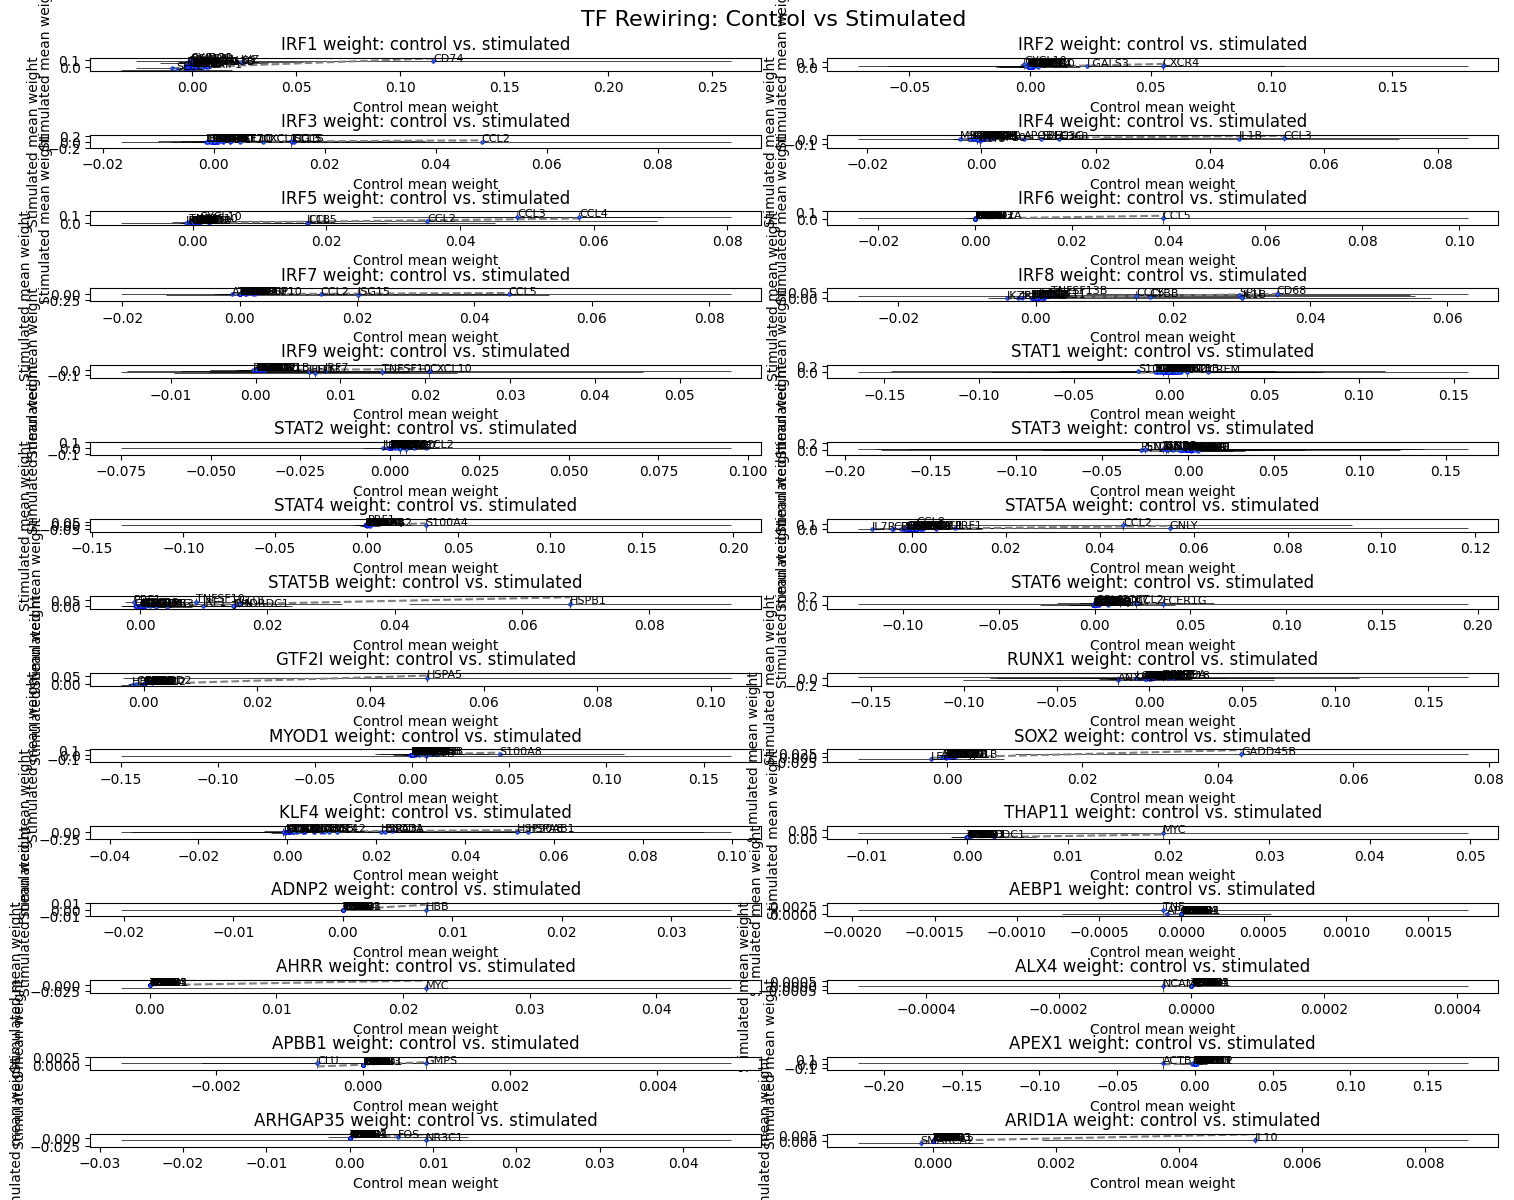

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_tf_rewiring(path, tf_names, title,
    n_cols=2, figsize=(15, 100)
):
    for root, dirs, files in os.walk(path):
        for filename in files:
            if 'bayes' in filename:
                if filename.endswith('uncertainty_mean.csv'):
                    if 'control' in filename:
                        file_path = os.path.join(root, filename)
                        sigma_weights_ctrl = pd.read_csv(file_path, index_col=0)
                    elif 'stimulated' in filename:
                        file_path = os.path.join(root, filename)
                        sigma_weights_stim = pd.read_csv(file_path, index_col=0)
            else:
                if filename.endswith('std.csv'):
                    if 'control' in filename:
                        file_path = os.path.join(root, filename)
                        sigma_weights_ctrl = pd.read_csv(file_path, index_col=0)
                    elif 'stimulated' in filename:
                        file_path = os.path.join(root, filename)
                        sigma_weights_stim = pd.read_csv(file_path, index_col=0)

            if filename.endswith('weight_mean.csv'):
                if 'control' in filename:
                    file_path = os.path.join(root, filename)
                    mean_weights_ctrl = pd.read_csv(file_path, index_col=0)
                elif 'stimulated' in filename:
                    file_path = os.path.join(root, filename)
                    mean_weights_stim = pd.read_csv(file_path, index_col=0)

    n_plots = len(tf_names)
    n_rows = (n_plots + n_cols - 1) // n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
    fig.suptitle(title, fontsize=16)

    for idx, tf_name in enumerate(tf_names):
        row, col = divmod(idx, n_cols)
        ax = axs[row][col]

        # Filter TF target genes
        stim = mean_weights_stim[tf_name].rename("stim")
        ctrl = mean_weights_ctrl[tf_name].rename("ctrl")

        std_stim = sigma_weights_stim[tf_name].rename("std_stim")
        std_ctrl = sigma_weights_ctrl[tf_name].rename("std_ctrl")

        merged = pd.concat([ctrl, stim, std_ctrl, std_stim], axis=1).dropna()
        merged["uncertainty"] = merged[["std_ctrl","std_stim"]].mean(axis=1)

        ax.errorbar(
            merged["ctrl"], merged["stim"],
            xerr=merged["std_ctrl"], yerr=merged["std_stim"],
            fmt='.',                 # circle markers
            ecolor='black',           # color of error bars
            elinewidth=0.5,          # thin error bars
            markersize=5,
            markeredgecolor='blue',
            markeredgewidth=0.5
        )

        ax.plot([merged["ctrl"].min(), merged["ctrl"].max()],
        [merged["ctrl"].min(), merged["ctrl"].max()],
        color='grey', linestyle='--')
        ax.set_xlabel("Control mean weight")
        ax.set_ylabel("Stimulated mean weight")
        ax.set_title(f"{tf_name} weight: control vs. stimulated")

        merged["dist"] = np.abs(merged["stim"] - merged["ctrl"]) / np.sqrt(2)
        top = merged.nlargest(20, "dist")
        for gene, row in top.iterrows():
            ax.annotate(gene, (row["ctrl"], row["stim"]), fontsize=8)

        plt.tight_layout()
    plt.show()

plot_tf_rewiring(
    path="save_model/vega",
    tf_names=['IRF1', 'IRF2', 'IRF3', 'IRF4', 'IRF5', 'IRF6', 'IRF7',
       'IRF8', 'IRF9', 'STAT1', 'STAT2', 'STAT3', 'STAT4', 'STAT5A',
       'STAT5B','STAT6','GTF2I','RUNX1', 'MYOD1', 'SOX2','KLF4', 'THAP11','ADNP2', 'AEBP1','AHRR', 'ALX4','APBB1','APEX1', 'ARHGAP35','ARID1A'],
    title="TF Rewiring: Control vs Stimulated",
)